In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython import display
%matplotlib inline

In [ ]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [2]:
x = np.zeros((100, 100))
y = np.ones((50, 100))
print(np.concatenate([x, y], axis=0).shape)

(150, 100)


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

4423680/4422102 [==============================] - 0s 0us/step


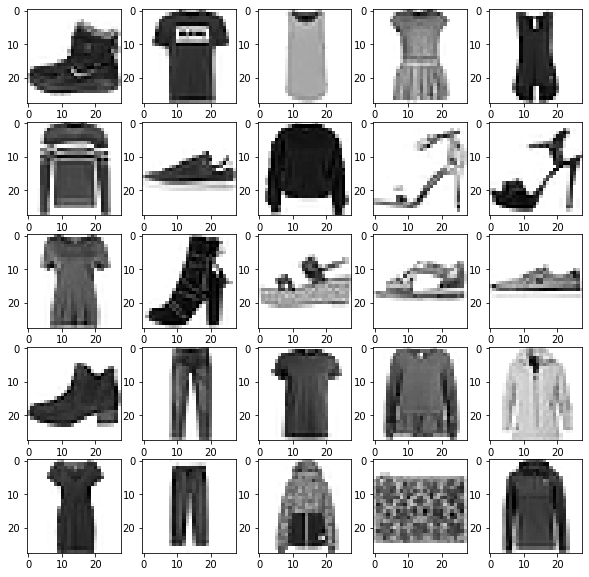

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.grid(False)
  plt.imshow(x_train[i], cmap=plt.cm.binary)

In [ ]:
batch_size=32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


In [ ]:
num_features = 100
generator = keras.models.Sequential([
                                     keras.layers.Dense(7*7*128, input_shape=[num_features]),
                                     keras.layers.Reshape([7,7,128]),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64,(5,5),(2,2),padding='same', activation='selu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1, (5,5),(2,2),padding='same', activation='tanh')])

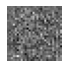

In [ ]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)
show(generated_image,1)

In [ ]:
discriminator = keras.models.Sequential([
                                         keras.layers.Conv2D(64,(5,5),(2,2),padding='same',input_shape=[28,28,1]),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Conv2D(128,(5,5),(2,2),padding='same'),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49767166]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [ ]:
seed = tf.random.normal(shape=[batch_size, 100])

In [ ]:
def generate_saveimage(model, epcoh, test_input):
  prediction = model(test_input, training=False)
  fig = plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(prediction[i,:,:,0]*127.5+127.5, cmap='binary')
    plt.axis('off')
  plt.savefig('image at epoch_{:04d}.png'.format(epcoh))
  plt.show()

In [ ]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
  generator, discriminator = gan.layers
  for epoch in tqdm(range(epochs)):
    print("Epochs {}/ {}".format(epoch+1, epochs))
    for i in dataset:
      noise = tf.random.normal(shape=[batch_size, num_features])
      generated_images = generator(noise)
      fake_real = tf.concat([generated_images, i], axis=0)
      y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
      
      discriminator.trainable = True
      discriminator.train_on_batch(fake_real, y1)

      y2 = tf.constant([[1.]]*batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    display.clear_output(wait=True)
    generate_saveimage(generator, epoch+1, seed)
  display.clear_output(wait=True)
  generate_saveimage(generator, epoch, seed)

In [ ]:
x_train_dcgan = x_train.reshape(-1, 28,28,1 )*2. -1.
batch_size=32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


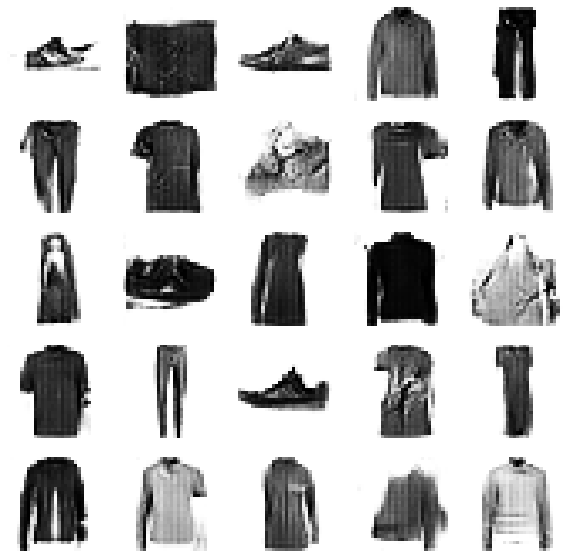

CPU times: user 7min 3s, sys: 34.6 s, total: 7min 38s
Wall time: 10min 48s


In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

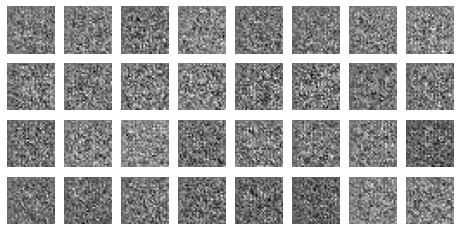

In [ ]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_image = generator(noise)
show(generated_image, 8)